In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import anndata as ad
from PIL import Image
from sklearn.cluster import KMeans

In [17]:
def extract_dominant_colors(image_path, n_colors=20, resize=200):
    # Open and resize the image
    image = Image.open(image_path).convert("RGB")
    image = image.resize((resize, resize))
    
    # Convert image to numpy array and reshape it to a 2D array of pixels
    img_array = np.array(image).reshape(-1, 3)

    # Perform KMeans clustering to find dominant colors
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(img_array)

    # Extract raw colors and pixel counts per cluster
    colors = kmeans.cluster_centers_.astype(int)
    counts = np.bincount(kmeans.labels_)

    # Sort by most common colors
    order = np.argsort(counts)[::-1]
    colors = colors[order]
    counts = counts[order]

    # Compute proportions
    proportions = counts / counts.sum()

    # Check if there are fewer colors than requested and pad with NA values
    if len(colors) < n_colors:
        # Add 'NA' color and zero proportions for missing colors
        na_color = [np.nan, np.nan, np.nan]  # NA color (RGB NaN)
        na_proportion = np.nan  # NA proportion (no pixels for these colors)
        
        # Pad both colors and proportions
        colors = np.vstack([colors, np.tile(na_color, (n_colors - len(colors), 1))])
        proportions = np.concatenate([proportions, np.repeat(na_proportion, n_colors - len(proportions))])

    return colors, proportions

In [18]:
def compute_contrasts(img_path, alpha=0.5, blur_sigma=1.0):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")

    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

   
    img_rgb = img_rgb.astype(np.float64)
    gray = gray.astype(np.float64)

    
    if blur_sigma > 0:
        gray = cv2.GaussianBlur(gray, (0, 0), blur_sigma)

    #Laplacian Filter
    laps = []
    for c in range(3):  
        lap = cv2.Laplacian(img_rgb[:, :, c], cv2.CV_64F)
        laps.append(np.abs(lap) / (np.abs(lap).max() + 1e-9))
    lap_gray = cv2.Laplacian(gray, cv2.CV_64F)
    laps.append(np.abs(lap_gray) / (np.abs(lap_gray).max() + 1e-9))
    laps = np.stack(laps, axis=-1)

    lap_overlap_map = np.min(laps, axis=-1)
    laplacian_overlap = np.mean(lap_overlap_map)

    #Sobel filter (gradient)
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    grad_mag /= grad_mag.max() + 1e-9
    gradient_energy = np.mean(grad_mag)

    
    hybrid_contrast_index = alpha * laplacian_overlap + (1 - alpha) * gradient_energy

    return laplacian_overlap, gradient_energy, hybrid_contrast_index

In [19]:
def build_paintings_anndata(paintings_info, image_folder):

    obs_rows = []
    X_rows = []

    for p in paintings_info:
        img_path = os.path.join(image_folder, p["filename"])
        if not os.path.exists(img_path):
            print(f"Skipping {p['Painting_name']} (file not found).")
            continue

        # Get colors and proportions
        colors, proportions = extract_dominant_colors(
            img_path, n_colors=20, resize=200
        )

        # Flatten colors (20 colors × 3 channels = 60 features)
        colors_flat = colors.flatten()
        X_rows.append(colors_flat)

        # Contrast features
        lap, grad, hybrid = compute_contrasts(img_path)

        # Build obs row
        row = {
            "Painting_index": p["Painting_index"],
            "Painting_name": p["Painting_name"],
            "Width": p["Width"],
            "Height": p["Height"],
            "Commission_Year": p["Commission_Year"],
            "Completion_Year": p["Completion_Year"],
            "Painter": p["Painter"],
            "sacred": int(p["sacred"]),
            "Jesuit_Art": int(p["Jesuit_Art"]),
            "Baroque_Art": int(p["Baroque_Art"]),
            "Laplacian_Contrast": lap,
            "Gradient_Contrast": grad,
            "Hybrid_Contrast": hybrid,
            "File Name": p["filename"]
        }

        # Add the 20 color proportions as obs metadata
        for i, prop in enumerate(proportions, start=1):
            row[f"color_prop_{i}"] = prop

        obs_rows.append(row)

    # Finalize obs and X
    obs = pd.DataFrame(obs_rows).set_index("Painting_index")
    X = np.vstack(X_rows)

    # Names for every RGB channel in X
    var_names = [
        f"color_{i}_{ch}"
        for i in range(1, 21)
        for ch in ["R", "G", "B"]
    ]

    adata = ad.AnnData(X=X, obs=obs, var=pd.DataFrame(index=var_names))
    return adata

In [20]:
paintings_info = [
    {
        "Painting_index": 1,
        "Painting_name": "David with the Head of Goliath",
        "Width": 91.3,
        "Height": 110.4,
        "Commission_Year": 1595,
        "Completion_Year": 1605,
        "Painter": "Michelangelo Merisi Caravaggio",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "David with the Head of Goliath.jpg"
    },
    {
        "Painting_index": 2,
        "Painting_name": "Santa Catalina",
        "Width": 128,
        "Height": 166,
        "Commission_Year": 1598,
        "Completion_Year": 1599,
        "Painter": "Michelangelo Merisi Caravaggio",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Santa Catalina.jpg"
    }
]


In [21]:
# "C:/Users/santy/Documents/Princeton University/COURSES/7. FALL SEMESTER 2025/SML 312 - STATISTICS PROJECT/Final Project/Data Set - Baroque Paintings/Baroque_paintings_repository"
image_folder = "C:/Users/santy/Documents/Princeton University/COURSES/7. FALL SEMESTER 2025/SML 312 - STATISTICS PROJECT/Final Project/Data Set - Baroque Paintings/Baroque_paintings_repository"

adata_paintings = build_paintings_anndata(paintings_info, image_folder)

C:\Users\santy\anaconda3\envs\SML312\Lib\functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


In [22]:
print(adata_paintings)
print("\n.obs preview:")
print(adata_paintings.obs.head())
print("\n.var names sample:")
print(adata_paintings.var_names[:6])

AnnData object with n_obs × n_vars = 2 × 60
    obs: 'Painting_name', 'Width', 'Height', 'Commission_Year', 'Completion_Year', 'Painter', 'sacred', 'Jesuit_Art', 'Baroque_Art', 'Laplacian_Contrast', 'Gradient_Contrast', 'Hybrid_Contrast', 'File Name', 'color_prop_1', 'color_prop_2', 'color_prop_3', 'color_prop_4', 'color_prop_5', 'color_prop_6', 'color_prop_7', 'color_prop_8', 'color_prop_9', 'color_prop_10', 'color_prop_11', 'color_prop_12', 'color_prop_13', 'color_prop_14', 'color_prop_15', 'color_prop_16', 'color_prop_17', 'color_prop_18', 'color_prop_19', 'color_prop_20'

.obs preview:
                                 Painting_name  Width  Height  \
Painting_index                                                  
1               David with the Head of Goliath   91.3   110.4   
2                               Santa Catalina  128.0   166.0   

                Commission_Year  Completion_Year  \
Painting_index                                     
1                          1595       

In [23]:
adata_paintings.obs

,Painting_name,Width,Height,Commission_Year,Completion_Year,Painter,sacred,Jesuit_Art,Baroque_Art,Laplacian_Contrast,...,color_prop_11,color_prop_12,color_prop_13,color_prop_14,color_prop_15,color_prop_16,color_prop_17,color_prop_18,color_prop_19,color_prop_20
Painting_index,,,,,,,,,,,,,,,,,,,,,
1,David with the Head of Goliath,91.3,110.4,1595,1605,Michelangelo Merisi Caravaggio,1,0,1,0.010107,...,0.021550,0.021075,0.018400,0.016725,0.016200,0.015300,0.014675,0.01435,0.007175,0.006875
2,Santa Catalina,128.0,166.0,1598,1599,Michelangelo Merisi Caravaggio,1,0,1,0.007477,...,0.010325,0.009775,0.008925,0.007775,0.007125,0.007075,0.005350,0.00465,0.003400,0.003400


In [24]:
adata_paintings.obs["color_prop_1"]

Painting_index
1    0.216800
2    0.479325
Name: color_prop_1, dtype: float64

In [25]:
adata_paintings.var

""
color_1_R
color_1_G
color_1_B
color_2_R
color_2_G
color_2_B
color_3_R
color_3_G
color_3_B
color_4_R


In [26]:
adata_paintings.X

array([[ 29,  24,  23,  35,  28,  26,  42,  33,  27,  50,  38,  29,  59,
         44,  31,  71,  53,  35,  83,  64,  42,  98,  75,  49, 112,  87,
         56, 181, 153, 110, 162, 125,  83, 176, 139,  95, 145, 110,  70,
        158, 139, 100, 129,  96,  60, 194, 163, 121, 141, 122,  86, 122,
        105,  74, 171, 160, 129, 193, 179, 147],
       [ 20,  21,  15,  23,  24,  17,  30,  27,  17,  42,  30,  17,  54,
         34,  16,  63,  45,  21,  80,  56,  19,  96,  70,  25,  92,  33,
         10, 192, 176, 135, 114,  87,  33,  72,  27,  12, 177, 145,  95,
        160, 130,  79, 136, 109,  57, 177, 161, 124, 157, 143, 110, 135,
        122,  88, 112,  99,  67,  82,  71,  45]])

In [27]:
pd.DataFrame(
    adata_paintings.X,
    index=adata_paintings.obs_names,
    columns=adata_paintings.var_names
).head()

,color_1_R,color_1_G,color_1_B,color_2_R,color_2_G,color_2_B,color_3_R,color_3_G,color_3_B,color_4_R,...,color_17_B,color_18_R,color_18_G,color_18_B,color_19_R,color_19_G,color_19_B,color_20_R,color_20_G,color_20_B
Painting_index,,,,,,,,,,,,,,,,,,,,,
1,29,24,23,35,28,26,42,33,27,50,...,86,122,105,74,171,160,129,193,179,147
2,20,21,15,23,24,17,30,27,17,42,...,110,135,122,88,112,99,67,82,71,45


In [28]:
import numpy as np
import matplotlib.pyplot as plt

def show_painting_palette(adata, painting_index, n_colors=20, figsize=(6, 1.5)):
    #Row index
    if painting_index not in adata.obs_names:
        raise ValueError(f"{painting_index} not found in adata.obs_names")

    row_idx = list(adata.obs_names).index(painting_index)

    # Extracting color data
    X_row = adata.X[row_idx]
    if not isinstance(X_row, np.ndarray):
        X_row = X_row.toarray().ravel()
    
    colors = X_row.reshape(n_colors, 3)
    
    # Normalizing the colors
    if colors.max() > 1.5:
        colors = colors / 255.0

    # Plotting the color palette
    fig, ax = plt.subplots(figsize=figsize)
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    
    ax.set_xlim(0, n_colors)
    ax.set_ylim(0, 1)
    ax.axis("off")

    painting_name = adata.obs.loc[painting_index, "Painting_name"]
    plt.title(f"Color Palette — {painting_name}", fontsize=10)
    plt.show()

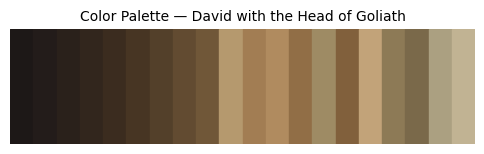

In [29]:
show_painting_palette(adata_paintings, painting_index="1")

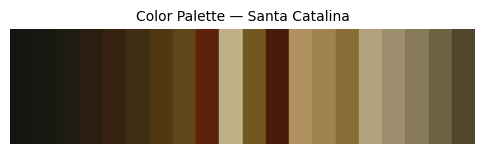

In [30]:
show_painting_palette(adata_paintings, painting_index="2")

# Complete Paintings Info

In [31]:
paintings_info_complete = [
    {
        "Painting_index": 1,
        "Painting_name": "David with the Head of Goliath",
        "Width": 91.3,
        "Height": 110.4,
        "Commission_Year": 1595,
        "Completion_Year": 1605,
        "Painter": "Michelangelo Merisi Caravaggio",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "David with the Head of Goliath.jpg"
    },
    {
        "Painting_index": 2,
        "Painting_name": "Santa Catalina",
        "Width": 128,
        "Height": 166,
        "Commission_Year": 1598,
        "Completion_Year": 1599,
        "Painter": "Michelangelo Merisi Caravaggio",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Santa Catalina.jpg"
    },
    {
        "Painting_index": 3,
        "Painting_name": "Imposición de la casulla a san Ildefonso",
        "Width": 55,
        "Height": 33,
        "Commission_Year": 1600,
        "Completion_Year": 1600,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Imposicion de la casulla a san Ildefonso.jpg"
    },
    {
        "Painting_index": 4,
        "Painting_name": "La Sagrada Familia",
        "Width": 23,
        "Height": 35,
        "Commission_Year": 1600,
        "Completion_Year": 1600,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "La Sagrada Familia.jpg"
    },
    {
        "Painting_index": 5,
        "Painting_name": "Vulcano y el fuego",
        "Width": 126,
        "Height": 140,
        "Commission_Year": 1600,
        "Completion_Year": 1600,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Vulcano y el fuego.jpg"
    },
    {
        "Painting_index": 6,
        "Painting_name": "El juicio de Paris",
        "Width": 114.5,
        "Height": 89,
        "Commission_Year": 1606,
        "Completion_Year": 1608,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "El juicio de Paris.jpg"
    },
    {
        "Painting_index": 7,
        "Painting_name": "Eolo",
        "Width": 126,
        "Height": 140,
        "Commission_Year": 1600,
        "Completion_Year": 1600,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Eolo.jpg"
    },
    {
        "Painting_index": 8,
        "Painting_name": "Filopómenes descubierto",
        "Width": 313.5,
        "Height": 201,
        "Commission_Year": 1604,
        "Completion_Year": 1614,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Filopomenes descubierto.jpg"
    },
    {
        "Painting_index": 9,
        "Painting_name": "Lucha de san Jorge y el dragón",
        "Width": 257,
        "Height": 309,
        "Commission_Year": 1606,
        "Completion_Year": 1608,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Lucha de san Jorge y el dragon.jpg"
    },
    {
        "Painting_index": 10,
        "Painting_name": "Paisaje con Psique y Júpiter",
        "Width": 129,
        "Height": 95,
        "Commission_Year": 1610,
        "Completion_Year": 1610,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Paisaje con Psique y Jupiter.jpg"
    },
    {
        "Painting_index": 11,
        "Painting_name": "Retrato ecuestre del duque de Lerma",
        "Width": 207.5,
        "Height": 290.5,
        "Commission_Year": 1603,
        "Completion_Year": 1603,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Retrato ecuestre del duque de Lerma.jpg"
    },
    {
        "Painting_index": 12,
        "Painting_name": "El archiduque Alberto de Austria",
        "Width": 177.5,
        "Height": 113.5,
        "Commission_Year": 1610,
        "Completion_Year": 1620,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "El archiduque Alberto de Austria.jpg"
    },
    {
        "Painting_index": 13,
        "Painting_name": "La Adoración de los Magos",
        "Width": 488,
        "Height": 349,
        "Commission_Year": 1608,
        "Completion_Year": 1629,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "La Adoracion de los Magos.jpg"
    },
    {
        "Painting_index": 14,
        "Painting_name": "Ninfas y sátiros",
        "Width": 167,
        "Height": 139.7,
        "Commission_Year": 1615,
        "Completion_Year": 1640,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Ninfas y satiros.jpg"
    },
    {
        "Painting_index": 15,
        "Painting_name": "San Andrés",
        "Width": 84,
        "Height": 108,
        "Commission_Year": 1610,
        "Completion_Year": 1612,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "San Andres.jpg"
    },
    {
        "Painting_index": 16,
        "Painting_name": "San Juan Evangelista",
        "Width": 83,
        "Height": 107.5,
        "Commission_Year": 1610,
        "Completion_Year": 1612,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "San Juan Evangelista.jpg"
    },
    {
        "Painting_index": 17,
        "Painting_name": "San Pedro",
        "Width": 82,
        "Height": 107,
        "Commission_Year": 1610,
        "Completion_Year": 1612,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "San Pedro.jpg"
    },
    {
        "Painting_index": 18,
        "Painting_name": "San Simóon",
        "Width": 82.5,
        "Height": 107.5,
        "Commission_Year": 1610,
        "Completion_Year": 1612,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "San Simon.jpg"
    },
    {
        "Painting_index": 19,
        "Painting_name": "Santiago el Menor",
        "Width": 82.5,
        "Height": 107,
        "Commission_Year": 1610,
        "Completion_Year": 1612,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Santiago el Menor.jpg"
    },
    {
        "Painting_index": 20,
        "Painting_name": "Santo Tomás",
        "Width": 83,
        "Height": 108,
        "Commission_Year": 1610,
        "Completion_Year": 1612,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Santo Tomas.jpg"
    },
    {
        "Painting_index": 21,
        "Painting_name": "El juicio de Salomón",
        "Width": 218.5,
        "Height": 184,
        "Commission_Year": 1611,
        "Completion_Year": 1614,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "El juicio de Salomon.jpg"
    },
    {
        "Painting_index": 22,
        "Painting_name": "La muerte de Séneca",
        "Width": 119.8,
        "Height": 181,
        "Commission_Year": 1612,
        "Completion_Year": 1615,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "La muerte de Seneca.jpg"
    },
    {
        "Painting_index": 23,
        "Painting_name": "Saint James the Greater",
        "Width": 83,
        "Height": 108,
        "Commission_Year": 1610,
        "Completion_Year": 1612,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint James the Greater.jpg"
    },
    {
        "Painting_index": 24,
        "Painting_name": "San Matías",
        "Width": 82.5,
        "Height": 107.2,
        "Commission_Year": 1610,
        "Completion_Year": 1612,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "San Matias.jpg"
    },
    {
        "Painting_index": 25,
        "Painting_name": "San Felipe",
        "Width": 82.5,
        "Height": 107,
        "Commission_Year": 1610,
        "Completion_Year": 1612,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "San Felipe.jpg"
    },
    {
        "Painting_index": 26,
        "Painting_name": "San Pablo",
        "Width": 83,
        "Height": 107.5,
        "Commission_Year": 1610,
        "Completion_Year": 1612,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "San Pablo.jpg"
    },
    {
        "Painting_index": 27,
        "Painting_name": "San Mateo",
        "Width": 82,
        "Height": 106.5,
        "Commission_Year": 1610,
        "Completion_Year": 1612,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "San Mateo.jpg"
    },
    {
        "Painting_index": 28,
        "Painting_name": "San Bartolomé",
        "Width": 82.5,
        "Height": 107,
        "Commission_Year": 1610,
        "Completion_Year": 1612,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "San Bartolome.jpg"
    },
    {
        "Painting_index": 29,
        "Painting_name": "Feston de flores y frutas y angelotes",
        "Width": 57,
        "Height": 177,
        "Commission_Year": 1620,
        "Completion_Year": 1620,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Feston de flores y frutas y angelotes.jpg"
    },
    {
        "Painting_index": 30,
        "Painting_name": "Ceres y Pan",
        "Width": 280.5,
        "Height": 178.5,
        "Commission_Year": 1620,
        "Completion_Year": 1620,
        "Painter": "Frans Snyders",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Ceres y Pan.jpg"
    },
    {
        "Painting_index": 31,
        "Painting_name": "Diana cazadora",
        "Width": 199,
        "Height": 184,
        "Commission_Year": 1615,
        "Completion_Year": 1625,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Diana cazadora.jpg"
    },
    {
        "Painting_index": 32,
        "Painting_name": "Tres ninfas con el cuerno de la abundancia",
        "Width": 166,
        "Height": 224.5,
        "Commission_Year": 1615,
        "Completion_Year": 1617,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Tres ninfas con el cuerno de la abundancia.jpg"
    },
    {
        "Painting_index": 33,
        "Painting_name": "La muerte del cónsul Decio",
        "Width": 140.5,
        "Height": 100,
        "Commission_Year": 1616,
        "Completion_Year": 1617,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "La muerte del consul Decio.jpg"
    },
    {
        "Painting_index": 34,
        "Painting_name": "La infanta Isabel Clara Eugenia",
        "Width": 175.8,
        "Height": 113,
        "Commission_Year": 1610,
        "Completion_Year": 1620,
        "Painter": "Peter Paul Rubens",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "La infanta Isabel Clara Eugenia.jpg"
    },
    {
        "Painting_index": 35,
        "Painting_name": "The Vocation of Saint Aloysius (Luigi) Gonzaga",
        "Width": 269.2,
        "Height": 355.6,
        "Commission_Year": 1650,
        "Completion_Year": 1650,
        "Painter": "Giovanni Francesco Barbieri",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Vocation of Saint Aloysius (Luigi) Gonzaga.jpg"
    },
    {
        "Painting_index": 36,
        "Painting_name": "The Lamentation",
        "Width": 172.7,
        "Height": 289.6,
        "Commission_Year": 1593,
        "Completion_Year": 1593,
        "Painter": "Scipione Pulzone",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Lamentation.jpg"
    },
    {
        "Painting_index": 37,
        "Painting_name": "The Immaculate Conception",
        "Width": 185.4,
        "Height": 268,
        "Commission_Year": 1627,
        "Completion_Year": 1627,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Immaculate Conception.jpg"
    },
    {
        "Painting_index": 38,
        "Painting_name": "The Tears of Saint Peter",
        "Width": 114.3,
        "Height": 161.9,
        "Commission_Year": 1612,
        "Completion_Year": 1613,
        "Painter": "Jusepe de Ribera",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Tears of Saint Peter.jpg"
    },
    {
        "Painting_index": 39,
        "Painting_name": "Burial of Christ",
        "Width": 144,
        "Height": 124,
        "Commission_Year": 1772,
        "Completion_Year": 1772,
        "Painter": "Giovanni Domenico Tiepolo",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Burial of Christ.jpg"
    },
    {
        "Painting_index": 40,
        "Painting_name": "Christ at the Column",
        "Width": 144,
        "Height": 124,
        "Commission_Year": 1772,
        "Completion_Year": 1772,
        "Painter": "Giovanni Domenico Tiepolo",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Christ at the Column.jpg"
    },
    {
        "Painting_index": 41,
        "Painting_name": "Christ falls on the Way to Calvary",
        "Width": 145,
        "Height": 124.3,
        "Commission_Year": 1772,
        "Completion_Year": 1772,
        "Painter": "Giovanni Domenico Tiepolo",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Christ falls on the Way to Calvary.jpg"
    },
    {
        "Painting_index": 42,
        "Painting_name": "The Adoration of the Magi",
        "Width": 125,
        "Height": 203,
        "Commission_Year": 1619,
        "Completion_Year": 1619,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Adoration of the Magi.jpg"
    },
    {
        "Painting_index": 43,
        "Painting_name": "The Agony in the Garden",
        "Width": 142,
        "Height": 125,
        "Commission_Year": 1772,
        "Completion_Year": 1772,
        "Painter": "Giovanni Domenico Tiepolo",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Agony in the Garden.jpg"
    },
    {
        "Painting_index": 44,
        "Painting_name": "The Burial of the Count of Orgaz",
        "Width": 248,
        "Height": 188,
        "Commission_Year": 1625,
        "Completion_Year": 1625,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Burial of the Count of Orgaz.jpg"
    },
    {
        "Painting_index": 45,
        "Painting_name": "The Crowning with Thorns",
        "Width": 144,
        "Height": 124,
        "Commission_Year": 1772,
        "Completion_Year": 1772,
        "Painter": "Giovanni Domenico Tiepolo",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Crowning with Thorns.jpg"
    },
    {
        "Painting_index": 46,
        "Painting_name": "The Crucifixion",
        "Width": 144,
        "Height": 124,
        "Commission_Year": 1772,
        "Completion_Year": 1772,
        "Painter": "Giovanni Domenico Tiepolo",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Crucifixion.jpg"
    },
    {
        "Painting_index": 47,
        "Painting_name": "The Dead Christ supported by an Angel",
        "Width": 119.8,
        "Height": 178.3,
        "Commission_Year": 1646,
        "Completion_Year": 1652,
        "Painter": "Alonso Cano",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Dead Christ supported by an Angel.jpg"
    },
    {
        "Painting_index": 48,
        "Painting_name": "The Descent from the Cross",
        "Width": 142,
        "Height": 124,
        "Commission_Year": 1772,
        "Completion_Year": 1772,
        "Painter": "Giovanni Domenico Tiepolo",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Descent from the Cross.jpg"
    },
    {
        "Painting_index": 49,
        "Painting_name": "The Immaculate Conception of El Escorial",
        "Width": 144,
        "Height": 206,
        "Commission_Year": 1660,
        "Completion_Year": 1670,
        "Painter": "Bartolomé Esteban Murillo",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Immaculate Conception of El Escorial.jpg"
    },
    {
        "Painting_index": 50,
        "Painting_name": "The Stripping of Christ",
        "Width": 144.5,
        "Height": 124.5,
        "Commission_Year": 1772,
        "Completion_Year": 1772,
        "Painter": "Giovanni Domenico Tiepolo",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Stripping of Christ.jpg"
    },
    {
        "Painting_index": 51,
        "Painting_name": "Apostle Judas Thaddäus",
        "Width": 49.7,
        "Height": 61.4,
        "Commission_Year": 1619,
        "Completion_Year": 1621,
        "Painter": "Anthonis van Dyck",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Apostle Judas Thaddaus.jpg"
    },
    {
        "Painting_index": 52,
        "Painting_name": "Apostle Philippus 161921",
        "Width": 50.7,
        "Height": 64.4,
        "Commission_Year": 1619,
        "Completion_Year": 1621,
        "Painter": "Anthonis van Dyck",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Apostle Philippus 161921.jpg"
    },
    {
        "Painting_index": 53,
        "Painting_name": "Apostle Simon 161921",
        "Width": 51.5,
        "Height": 64,
        "Commission_Year": 1619,
        "Completion_Year": 1621,
        "Painter": "Anthonis van Dyck",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Apostle Simon 161921.jpg"
    },
    {
        "Painting_index": 54,
        "Painting_name": "Der Evangelist Johannes spendet der Jungfrau Maria die letzte Kommunion",
        "Width": 240,
        "Height": 157,
        "Commission_Year": 1630,
        "Completion_Year": 1634,
        "Painter": "Gerard Seghers",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Der Evangelist Johannes spendet der Jungfrau Maria die letzte Kommunion.jpg"
    },
    {
        "Painting_index": 55,
        "Painting_name": "Heilige Familie im Blumenkranz",
        "Width": 54.5,
        "Height": 82.5,
        "Commission_Year": 1644,
        "Completion_Year": 1644,
        "Painter": "Daniel Seghers",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Heilige Familie im Blumenkranz.jpg"
    },
    {
        "Painting_index": 56,
        "Painting_name": "Interior of the Jesuit Church in Antwerp",
        "Width": 70.7,
        "Height": 52,
        "Commission_Year": 1630,
        "Completion_Year": 1630,
        "Painter": "Sebastian Vrancx",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Interior of the Jesuit Church in Antwerp.jpg"
    },
    {
        "Painting_index": 57,
        "Painting_name": "Interior of the Jesuit Church in Antwerp_2",
        "Width": 141,
        "Height": 113,
        "Commission_Year": 1665,
        "Completion_Year": 1665,
        "Painter": "Anton Günther Gheringh",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Interior of the Jesuit Church in Antwerp_2.jpg"
    },
    {
        "Painting_index": 58,
        "Painting_name": "Maria mit Kind und hl. Anna im Blumenkranz",
        "Width": 54.5,
        "Height": 82.5,
        "Commission_Year": 1644,
        "Completion_Year": 1644,
        "Painter": "Daniel Seghers",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Maria mit Kind und hl. Anna im Blumenkranz.jpg"
    },
    {
        "Painting_index": 59,
        "Painting_name": "Mary with Child and Saint Rosalie, Peter and Paul",
        "Width": 210,
        "Height": 275,
        "Commission_Year": 1629,
        "Completion_Year": 1629,
        "Painter": "Anthonis van Dyck",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Mary with Child and Saint Rosalie, Peter and Paul.jpg"
    },
    {
        "Painting_index": 60,
        "Painting_name": "P. Carolus Scribani S. J",
        "Width": 103.5,
        "Height": 118.5,
        "Commission_Year": 1629,
        "Completion_Year": 1629,
        "Painter": "Anthonis van Dyck",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "P. Carolus Scribani S. J.jpg"
    },
    {
        "Painting_index": 61,
        "Painting_name": "Saint Francis in Ecstasy",
        "Width": 97,
        "Height": 119.5,
        "Commission_Year": 1630,
        "Completion_Year": 1632,
        "Painter": "Anthonis van Dyck",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Saint Francis in Ecstasy.jpg"
    },
    {
        "Painting_index": 62,
        "Painting_name": "St. Michael Vanquishing the Devils",
        "Width": 283,
        "Height": 419,
        "Commission_Year": 1630,
        "Completion_Year": 1632,
        "Painter": "Luca Giordano",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "St. Michael Vanquishing the Devils.jpg"
    },
    {
        "Painting_index": 63,
        "Painting_name": "The Annunciation",
        "Width": 202,
        "Height": 225,
        "Commission_Year": 1610,
        "Completion_Year": 1610,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Annunciation.jpg"
    },
    {
        "Painting_index": 64,
        "Painting_name": "The Assumption of the Virgin Mary",
        "Width": 297,
        "Height": 458,
        "Commission_Year": 1611,
        "Completion_Year": 1624,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Assumption of the Virgin Mary.jpg"
    },
    {
        "Painting_index": 65,
        "Painting_name": "The Miracles of St. Francis Xavier",
        "Width": 395,
        "Height": 535,
        "Commission_Year": 1617,
        "Completion_Year": 1618,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Miracles of St. Francis Xavier.jpg"
    },
    {
        "Painting_index": 66,
        "Painting_name": "The Miracles of St. Ignatius of Loyola",
        "Width": 395,
        "Height": 535,
        "Commission_Year": 1617,
        "Completion_Year": 1618,
        "Painter": "Peter Paul Rubens",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Miracles of St. Ignatius of Loyola.jpg"
    },
    {
        "Painting_index": 67,
        "Painting_name": "The Vision of saint Hermann Joseph with Mary",
        "Width": 129,
        "Height": 159.5,
        "Commission_Year": 1630,
        "Completion_Year": 1630,
        "Painter": "Anthonis van Dyck",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Vision of saint Hermann Joseph with Mary.jpg"
    },
    {
        "Painting_index": 68,
        "Painting_name": "Verkündigung an Maria",
        "Width": 238,
        "Height": 333,
        "Commission_Year": 1620,
        "Completion_Year": 1630,
        "Painter": "Anthonis van Dyck",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "Verkundigung an Maria.jpg"
    },
    {
        "Painting_index": 69,
        "Painting_name": "A Sybil",
        "Width": 50,
        "Height":  62,
        "Commission_Year": 1632,
        "Completion_Year": 1632,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "A Sybil.jpg"
    },
    {
        "Painting_index": 70,
        "Painting_name": "Antonia de Ipeñarrieta y Galdós, y su hijo Luis",
        "Width": 115,
        "Height": 206,
        "Commission_Year": 1632,
        "Completion_Year": 1632,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Antonia de Ipenarrieta y Galdos, y su hijo Luis.jpg"
    },
    {
        "Painting_index": 71,
        "Painting_name": "Apostle’s Head",
        "Width": 29,
        "Height": 38,
        "Commission_Year": 1619,
        "Completion_Year": 1620,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Apostles Head.jpg"
    },
    {
        "Painting_index": 72,
        "Painting_name": "Crucified Christ",
        "Width": 169,
        "Height": 248,
        "Commission_Year": 1632,
        "Completion_Year": 1632,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Crucified Christ.jpg"
    },
    {
        "Painting_index": 73,
        "Painting_name": "Diego del Corral y Arellano",
        "Width": 115,
        "Height": 206,
        "Commission_Year": 1632,
        "Completion_Year": 1632,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Diego del Corral y Arellano.jpg"
    },
    {
        "Painting_index": 74,
        "Painting_name": "El príncipe Baltasar Carlos",
        "Width": 96,
        "Height": 121,
        "Commission_Year": 1635,
        "Completion_Year": 1635,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "El principe Baltasar Carlos.jpg"
    },
    {
        "Painting_index": 75,
        "Painting_name": "Francisco Pacheco",
        "Width": 36,
        "Height": 41,
        "Commission_Year": 1620,
        "Completion_Year": 1620,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Francisco Pacheco.jpg"
    },
    {
        "Painting_index": 76,
        "Painting_name": "Head of a Deer",
        "Width": 52,
        "Height": 66,
        "Commission_Year": 1626,
        "Completion_Year": 1636,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Head of a Deer.jpg"
    },
    {
        "Painting_index": 77,
        "Painting_name": "Infante Don Carlos",
        "Width": 125,
        "Height": 209,
        "Commission_Year": 1626,
        "Completion_Year": 1627,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Infante Don Carlos.jpg"
    },
    {
        "Painting_index": 78,
        "Painting_name": "Juan Martínez Montañés",
        "Width": 88,
        "Height": 109,
        "Commission_Year": 1635,
        "Completion_Year": 1635,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Juan Martinez Montanes.jpg"
    },
    {
        "Painting_index": 79,
        "Painting_name": "Pablo de Valladolid",
        "Width": 123,
        "Height": 209,
        "Commission_Year": 1635,
        "Completion_Year": 1635,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Pablo de Valladolid.jpg"
    },
    {
        "Painting_index": 80,
        "Painting_name": "Philip III on Horseback",
        "Width": 212,
        "Height": 300,
        "Commission_Year": 1635,
        "Completion_Year": 1635,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Philip III on Horseback.jpg"
    },
    {
        "Painting_index": 81,
        "Painting_name": "Philip III",
        "Width": 37,
        "Height": 45.5,
        "Commission_Year": 1627,
        "Completion_Year": 1627,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Philip III.jpg"
    },
    {
        "Painting_index": 82,
        "Painting_name": "Philip IV on Horseback",
        "Width": 317,
        "Height": 303,
        "Commission_Year": 1635,
        "Completion_Year": 1635,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Philip IV on Horseback.jpg"
    },
    {
        "Painting_index": 83,
        "Painting_name": "Philip IV",
        "Width": 101.5,
        "Height": 198,
        "Commission_Year": 1623,
        "Completion_Year": 1628,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Philip IV.jpg"
    },
    {
        "Painting_index": 84,
        "Painting_name": "Portrait of a Man",
        "Width": 38,
        "Height": 55.5,
        "Commission_Year": 1623,
        "Completion_Year": 1623,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Portrait of a Man.jpg"
    },
    {
        "Painting_index": 85,
        "Painting_name": "Queen Elisabeth of France, on Horseback",
        "Width": 314,
        "Height": 301,
        "Commission_Year": 1635,
        "Completion_Year": 1635,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Queen Elisabeth of France, on Horseback.jpg"
    },
    {
        "Painting_index": 86,
        "Painting_name": "Queen Margaret of Austria on Horseback",
        "Width": 212,
        "Height": 297,
        "Commission_Year": 1635,
        "Completion_Year": 1635,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Queen Margaret of Austria on Horseback.jpg"
    },
    {
        "Painting_index": 87,
        "Painting_name": "Saints Anthony Abbot and Paul the Hermit",
        "Width": 192.5,
        "Height": 261,
        "Commission_Year": 1634,
        "Completion_Year": 1634,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saints Anthony Abbot and Paul the Hermit.jpg"
    },
    {
        "Painting_index": 88,
        "Painting_name": "The Feast of Bacchus",
        "Width": 225,
        "Height": 165,
        "Commission_Year": 1628,
        "Completion_Year": 1629,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Feast of Bacchus.jpg"
    },
    {
        "Painting_index": 89,
        "Painting_name": "The Nun Jerónima de la Fuente",
        "Width": 110,
        "Height": 160,
        "Commission_Year": 1620,
        "Completion_Year": 1620,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Nun Jeronima de la Fuente.jpg"
    },
    {
        "Painting_index": 90,
        "Painting_name": "The Surrender of Breda",
        "Width": 371.5,
        "Height": 307.3,
        "Commission_Year": 1635,
        "Completion_Year": 1635,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Surrender of Breda.jpg"
    },
    {
        "Painting_index": 91,
        "Painting_name": "View of the Gardens of the Villa Medici, Rome, with a Statue of Ariadne",
        "Width": 38,
        "Height": 44,
        "Commission_Year": 1630,
        "Completion_Year": 1630,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "View of the Gardens of the Villa Medici, Rome, with a Statue of Ariadne.jpg"
    },
    {
        "Painting_index": 92,
        "Painting_name": "View of the Gardens of the Villa Medici, Rome",
        "Width": 43,
        "Height": 48.5,
        "Commission_Year": 1630,
        "Completion_Year": 1630,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "View of the Gardens of the Villa Medici, Rome.jpg"
    },
    {
        "Painting_index": 93,
        "Painting_name": "Vulcan's Forge",
        "Width": 290,
        "Height": 223,
        "Commission_Year": 1630,
        "Completion_Year": 1630,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Vulcans Forge.jpg"
    },
    {
        "Painting_index": 94,
        "Painting_name": "Buffon with a Dog",
        "Width": 107,
        "Height": 142,
        "Commission_Year": 1645,
        "Completion_Year": 1645,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Buffon with a Dog.jpg"
    },
    {
        "Painting_index": 95,
        "Painting_name": "Cacería de jabalíes en el Hoyo",
        "Width": 303,
        "Height": 188,
        "Commission_Year": 1650,
        "Completion_Year": 1650,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Caceria de jabalies en el Hoyo.jpg"
    },
    {
        "Painting_index": 96,
        "Painting_name": "Cardinal-Infante Ferdinand of Austria, in Hunting Dress",
        "Width": 107,
        "Height": 191,
        "Commission_Year": 1650,
        "Completion_Year": 1650,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Cardinal_Infante Ferdinand of Austria, in Hunting Dress.jpg"
    },
    {
        "Painting_index": 97,
        "Painting_name": "Gaspar de Guzman, Count_Duke of Olivares, on Horseback",
        "Width": 242.5,
        "Height": 313,
        "Commission_Year": 1636,
        "Completion_Year": 1636,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Gaspar de Guzman, Count_Duke of Olivares, on Horseback.jpg"
    },
    {
        "Painting_index": 98,
        "Painting_name": "Juan Francisco de Pimentel, Count of Benavente",
        "Width": 88,
        "Height": 109,
        "Commission_Year": 1648,
        "Completion_Year": 1648,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Juan Francisco de Pimentel, Count of Benavente.jpg"
    },
    {
        "Painting_index": 99,
        "Painting_name": "Las Meninas",
        "Width": 279.1,
        "Height": 320.3,
        "Commission_Year": 1656,
        "Completion_Year": 1656,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Las Meninas.jpg"
    },
    {
        "Painting_index": 100,
        "Painting_name": "Mariana de Austria in Prayer",
        "Width": 279.1,
        "Height": 320.3,
        "Commission_Year": 1655,
        "Completion_Year": 1655,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Mariana de Austria in Prayer.jpg"
    },
    {
        "Painting_index": 101,
        "Painting_name": "Mars",
        "Width": 95,
        "Height": 179,
        "Commission_Year": 1638,
        "Completion_Year": 1638,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Mars.jpg"
    },
    {
        "Painting_index": 102,
        "Painting_name": "Philip IV in Armour, with a Lion at his Feet",
        "Width": 131.5,
        "Height": 234,
        "Commission_Year": 1653,
        "Completion_Year": 1653,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Philip IV in Armour, with a Lion at his Feet.jpg"
    },
    {
        "Painting_index": 103,
        "Painting_name": "Philip IV in Hunting Dress",
        "Width": 124,
        "Height": 189,
        "Commission_Year": 1632,
        "Completion_Year": 1634,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Philip IV in Hunting Dress.jpg"
    },
    {
        "Painting_index": 104,
        "Painting_name": "Philip IV in prayer",
        "Width": 147,
        "Height": 209,
        "Commission_Year": 1655,
        "Completion_Year": 1655,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Philip IV in prayer.jpg"
    },
    {
        "Painting_index": 105,
        "Painting_name": "Philip IV_2",
        "Width": 56.5,
        "Height": 69.3,
        "Commission_Year": 1653,
        "Completion_Year": 1653,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Philip IV_2.jpg"
    },
    {
        "Painting_index": 106,
        "Painting_name": "Prince Baltasar Carlos in Hunting Dress",
        "Width": 103,
        "Height": 191,
        "Commission_Year": 1635,
        "Completion_Year": 1636,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Prince Baltasar Carlos in Hunting Dress.jpg"
    },
    {
        "Painting_index": 107,
        "Painting_name": "Prince Baltasar Carlos in Hunting Dress",
        "Width": 103,
        "Height": 191,
        "Commission_Year": 1635,
        "Completion_Year": 1636,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Prince Baltasar Carlos in Hunting Dress.jpg"
    },
    {
        "Painting_index": 108,
        "Painting_name": "Prince Baltasar Carlos on Horseback",
        "Width": 177,
        "Height": 211.5,
        "Commission_Year": 1634,
        "Completion_Year": 1635,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Prince Baltasar Carlos on Horseback.jpg"
    },
    {
        "Painting_index": 109,
        "Painting_name": "Prince Baltasar Carlos_2",
        "Width": 113,
        "Height": 158,
        "Commission_Year": 1636,
        "Completion_Year": 1636,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Prince Baltasar Carlos_2.jpg"
    },
    {
        "Painting_index": 110,
        "Painting_name": "Queen Mariana of Austria",
        "Width": 132,
        "Height": 234.2,
        "Commission_Year": 1652,
        "Completion_Year": 1653,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Queen Mariana of Austria.jpg"
    },
    {
        "Painting_index": 111,
        "Painting_name": "The Buffoon El Primo",
        "Width": 82.5,
        "Height": 106.5,
        "Commission_Year": 1644,
        "Completion_Year": 1644,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Buffoon El Primo.jpg"
    },
    {
        "Painting_index": 112,
        "Painting_name": "The Buffoon Juan de Austria",
        "Width": 123,
        "Height": 210,
        "Commission_Year": 1632,
        "Completion_Year": 1632,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Buffoon Juan de Austria.jpg"
    },
    {
        "Painting_index": 113,
        "Painting_name": "The Coronation of the Virgin",
        "Width": 134.5,
        "Height": 178.5,
        "Commission_Year": 1635,
        "Completion_Year": 1636,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Coronation of the Virgin.jpg"
    },
    {
        "Painting_index": 114,
        "Painting_name": "The Fountain of the Tritons in the Island Garden, Aranjuez",
        "Width": 223,
        "Height": 248,
        "Commission_Year": 1657,
        "Completion_Year": 1657,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Fountain of the Tritons in the Island Garden, Aranjuez.jpg"
    },
    {
        "Painting_index": 115,
        "Painting_name": "The Spinners, or the Fable of Arachne",
        "Width": 289,
        "Height": 220,
        "Commission_Year": 1655,
        "Completion_Year": 1660,
        "Painter": "Diego Rodríguez de Silva y Velázquez",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Spinners, or the Fable of Arachne.jpg"
    },
    {
        "Painting_index": 116,
        "Painting_name": "A Maid Asleep",
        "Width": 76.5,
        "Height": 87.6,
        "Commission_Year": 1656,
        "Completion_Year": 1657,
        "Painter": "Johannes Vermeer",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "A Maid Asleep.jpg"
    },
    {
        "Painting_index": 117,
        "Painting_name": "Allegory of the Catholic Faith",
        "Width": 88.9,
        "Height": 114.3,
        "Commission_Year": 1670,
        "Completion_Year": 1672,
        "Painter": "Johannes Vermeer",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "A Maid Asleep.jpg"
    },
    {
        "Painting_index": 118,
        "Painting_name": "Young Woman with a Lute",
        "Width": 45.7,
        "Height": 51.4,
        "Commission_Year": 1662,
        "Completion_Year": 1663,
        "Painter": "Johannes Vermeer",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Young Woman with a Lute.jpg"
    },
    {
        "Painting_index": 119,
        "Painting_name": "Young Woman with a Water Pitcher",
        "Width": 40.6,
        "Height": 45.7,
        "Commission_Year": 1662,
        "Completion_Year": 1662,
        "Painter": "Johannes Vermeer",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Young Woman with a Water Pitcher.jpg"
    },
    {
        "Painting_index": 120,
        "Painting_name": "Study of a Young Woman",
        "Width": 40,
        "Height": 44.5,
        "Commission_Year": 1665,
        "Completion_Year": 1667,
        "Painter": "Johannes Vermeer",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Study of a Young Woman.jpg"
    },
    {
        "Painting_index": 121,
        "Painting_name": "Judith at the Banquet of Holofernes",
        "Width": 154.7,
        "Height": 143,
        "Commission_Year": 1634,
        "Completion_Year": 1634,
        "Painter": "Rembrandt Harmenszoon van Rijn",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Judith at the Banquet of Holofernes.jpg"
    },
    {
        "Painting_index": 122,
        "Painting_name": "Cabeza de apostol",
        "Width": 45,
        "Height": 61,
        "Commission_Year": 1625,
        "Completion_Year": 1625,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Cabeza de apostol.jpg"
    },
    {
        "Painting_index": 123,
        "Painting_name": "Charity",
        "Width": 110,
        "Height": 141,
        "Commission_Year": 1625,
        "Completion_Year": 1625,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Charity.jpg"
    },
    {
        "Painting_index": 124,
        "Painting_name": "Cleopatra",
        "Width": 94,
        "Height": 110,
        "Commission_Year": 1621,
        "Completion_Year": 1626,
        "Painter": "Guido Reni",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Cleopatra.jpg"
    },
    {
        "Painting_index": 125,
        "Painting_name": "El Arcangel San Miguel",
        "Width": 33,
        "Height": 42,
        "Commission_Year": 1625,
        "Completion_Year": 1625,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "El Arcangel San Miguel.jpg"
    },
    {
        "Painting_index": 126,
        "Painting_name": "Hippomenes and Atalanta",
        "Width": 279,
        "Height": 206,
        "Commission_Year": 1618,
        "Completion_Year": 1619,
        "Painter": "Guido Reni",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Hippomenes and Atalanta.jpg"
    },
    {
        "Painting_index": 127,
        "Painting_name": "Lucrecia dandose muerte",
        "Width": 147,
        "Height": 218,
        "Commission_Year": 1625,
        "Completion_Year": 1625,
        "Painter": "Guido Reni",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Lucrecia dandose muerte.jpg"
    },
    {
        "Painting_index": 128,
        "Painting_name": "Lucretia killing herself",
        "Width": 57.3,
        "Height": 70.5,
        "Commission_Year": 1625,
        "Completion_Year": 1625,
        "Painter": "Guido Reni",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Lucretia killing herself.jpg"
    },
    {
        "Painting_index": 129,
        "Painting_name": "Saint Apollonia in Prayer",
        "Width": 20,
        "Height": 28,
        "Commission_Year": 1600,
        "Completion_Year": 1603,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Apollonia in Prayer.jpg"
    },
    {
        "Painting_index": 130,
        "Painting_name": "Saint Catherine of Alexandria",
        "Width": 75,
        "Height": 98,
        "Commission_Year": 1606,
        "Completion_Year": 1606,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Catherine of Alexandria.jpg"
    },
    {
        "Painting_index": 131,
        "Painting_name": "Saint James the Greater_2",
        "Width": 89,
        "Height": 135,
        "Commission_Year": 1626,
        "Completion_Year": 1626,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint James the Greater_2.jpg"
    },
    {
        "Painting_index": 132,
        "Painting_name": "Saint Jerome_2",
        "Width": 56,
        "Height": 65,
        "Commission_Year": 1623,
        "Completion_Year": 1633,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Jerome_2.jpg"
    },
    {
        "Painting_index": 133,
        "Painting_name": "Saint Mary Magdalene",
        "Width": 62,
        "Height": 75,
        "Commission_Year": 1625,
        "Completion_Year": 1625,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Mary Magdalene.jpg"
    },
    {
        "Painting_index": 134,
        "Painting_name": "Saint Peter_2",
        "Width": 61,
        "Height": 76,
        "Commission_Year": 1633,
        "Completion_Year": 1634,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Peter_2.jpg"
    },
    {
        "Painting_index": 135,
        "Painting_name": "Saint Sebastian",
        "Width": 134.5,
        "Height": 172,
        "Commission_Year": 1619,
        "Completion_Year": 1619,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Sebastian.jpg"
    },
    {
        "Painting_index": 136,
        "Painting_name": "The Assumption and Coronation of the Virgin",
        "Width": 51,
        "Height": 77,
        "Commission_Year": 1602,
        "Completion_Year": 1603,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Assumption and Coronation of the Virgin.jpg"
    },
    {
        "Painting_index": 137,
        "Painting_name": "The Martyrdom of Saint Apollonia",
        "Width": 20,
        "Height": 28,
        "Commission_Year": 1600,
        "Completion_Year": 1603,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Martyrdom of Saint Apollonia.jpg"
    },
    {
        "Painting_index": 138,
        "Painting_name": "The Virgin of the Chair",
        "Width": 137.5,
        "Height": 213.8,
        "Commission_Year": 1624,
        "Completion_Year": 1625,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Virgin of the Chair.jpg"
    },
    {
        "Painting_index": 139,
        "Painting_name": "An Elderly Gentleman",
        "Width": 43,
        "Height": 46,
        "Commission_Year": 1587,
        "Completion_Year": 1600,
        "Painter": "El Greco",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "An Elderly Gentleman.jpg"
    },
    {
        "Painting_index": 140,
        "Painting_name": "Cupid with a Bow",
        "Width": 88,
        "Height": 101,
        "Commission_Year": 1637,
        "Completion_Year": 1638,
        "Painter": "Guido Reni",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Cupid with a Bow.jpg"
    },
    {
        "Painting_index": 141,
        "Painting_name": "Saint Paul_2",
        "Width": 61,
        "Height": 76,
        "Commission_Year": 1633,
        "Completion_Year": 1634,
        "Painter": "Guido Reni",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Paul_2.jpg"
    },
    {
        "Painting_index": 142,
        "Painting_name": "Muchacha con una rosa",
        "Width": 62,
        "Height": 81,
        "Commission_Year": 1636,
        "Completion_Year": 1637,
        "Painter": "Guido Reni",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Muchacha con una rosa.jpg"
    },
    {
        "Painting_index": 143,
        "Painting_name": "Fable",
        "Width": 63.6,
        "Height": 50.5,
        "Commission_Year": 1580,
        "Completion_Year": 1580,
        "Painter": "El Greco",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Fable.jpg"
    },
    {
        "Painting_index": 144,
        "Painting_name": "Pentecost",
        "Width": 127,
        "Height": 275,
        "Commission_Year": 1600,
        "Completion_Year": 1600,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Pentecost.jpg"
    },
    {
        "Painting_index": 145,
        "Painting_name": "Portrait of a Doctor",
        "Width": 82.3,
        "Height": 96,
        "Commission_Year": 1582,
        "Completion_Year": 1585,
        "Painter": "El Greco",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Portrait of a Doctor.jpg"
    },
    {
        "Painting_index": 146,
        "Painting_name": "Portrait of a Gentleman",
        "Width": 55,
        "Height": 67,
        "Commission_Year": 1586,
        "Completion_Year": 1586,
        "Painter": "El Greco",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Portrait of a Gentleman.jpg"
    },
    {
        "Painting_index": 147,
        "Painting_name": "Saint Anthony of Padua",
        "Width": 79,
        "Height": 104,
        "Commission_Year": 1580,
        "Completion_Year": 1580,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Anthony of Padua.jpg"
    },
    {
        "Painting_index": 148,
        "Painting_name": "Saint Benedict",
        "Width": 81,
        "Height": 116,
        "Commission_Year": 1577,
        "Completion_Year": 1579,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Benedict.jpg"
    },
    {
        "Painting_index": 149,
        "Painting_name": "Saints Andrew and Francis",
        "Width": 113,
        "Height": 167,
        "Commission_Year": 1595,
        "Completion_Year": 1595,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saints Andrew and Francis.jpg"
    },
    {
        "Painting_index": 150,
        "Painting_name": "The Annunciation_2",
        "Width": 20,
        "Height": 26.7,
        "Commission_Year": 1570,
        "Completion_Year": 1572,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Annunciation_2.jpg"
    },
    {
        "Painting_index": 151,
        "Painting_name": "The Annunciation_3",
        "Width": 174,
        "Height": 315,
        "Commission_Year": 1597,
        "Completion_Year": 1600,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Annunciation_2.jpg"
    },
    {
        "Painting_index": 152,
        "Painting_name": "The Coronation of the Virgin_2",
        "Width": 101,
        "Height": 99,
        "Commission_Year": 1592,
        "Completion_Year": 1592,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Coronation of the Virgin_2.jpg"
    },
    {
        "Painting_index": 153,
        "Painting_name": "The Flight into Egypt",
        "Width": 21.6,
        "Height": 15.9,
        "Commission_Year": 1570,
        "Completion_Year": 1570,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Flight into Egypt.jpg"
    },
    {
        "Painting_index": 154,
        "Painting_name": "The Holy Family with Saint Anne and the Infant Saint John",
        "Width": 70,
        "Height": 108.5,
        "Commission_Year": 1600,
        "Completion_Year": 1600,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Holy Family with Saint Anne and the Infant Saint John.jpg"
    },
    {
        "Painting_index": 155,
        "Painting_name": "The Holy Trinity",
        "Width": 179,
        "Height": 300,
        "Commission_Year": 1577,
        "Completion_Year": 1579,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Holy Trinity.jpg"
    },
    {
        "Painting_index": 156,
        "Painting_name": "The Nobleman with his Hand on his Chest",
        "Width": 66.1,
        "Height": 81.8,
        "Commission_Year": 1580,
        "Completion_Year": 1580,
        "Painter": "El Greco",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Nobleman with his Hand on his Chest.jpg"
    },
    {
        "Painting_index": 157,
        "Painting_name": "The Resurrection",
        "Width": 127,
        "Height": 275,
        "Commission_Year": 1597,
        "Completion_Year": 1600,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Resurrection.jpg"
    },
    {
        "Painting_index": 158,
        "Painting_name": "The Veil of Saint Veronica",
        "Width": 54,
        "Height": 71,
        "Commission_Year": 1586,
        "Completion_Year": 1595,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Veil of Saint Veronica.jpg"
    },
    {
        "Painting_index": 159,
        "Painting_name": "The Virgin Mary",
        "Width": 41,
        "Height": 52,
        "Commission_Year": 1595,
        "Completion_Year": 1600,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Virgin Mary.jpg"
    },
    {
        "Painting_index": 160,
        "Painting_name": "The Adoration of the Shepherds",
        "Width": 319,
        "Height": 180,
        "Commission_Year": 1612,
        "Completion_Year": 1614,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Adoration of the Shepherds.jpg"
    },
    {
        "Painting_index": 161,
        "Painting_name": "Saint Sebastian_2",
        "Width": 111.5,
        "Height": 201.5,
        "Commission_Year": 1610,
        "Completion_Year": 1614,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Sebastian_2.jpg"
    },
    {
        "Painting_index": 162,
        "Painting_name": "Saint James the Elder",
        "Width": 55,
        "Height": 72,
        "Commission_Year": 1608,
        "Completion_Year": 1614,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint James the Elder.jpg"
    },
    {
        "Painting_index": 163,
        "Painting_name": "Apostle",
        "Width": 56,
        "Height": 72,
        "Commission_Year": 1608,
        "Completion_Year": 1614,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Apostle.jpg"
    },
    {
        "Painting_index": 164,
        "Painting_name": "Saint Paul_3",
        "Width": 55,
        "Height": 72,
        "Commission_Year": 1608,
        "Completion_Year": 1614,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Paul_3.jpg"
    },
    {
        "Painting_index": 165,
        "Painting_name": "Christ the Saviour",
        "Width": 55,
        "Height": 72,
        "Commission_Year": 1608,
        "Completion_Year": 1614,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Christ the Saviour.jpg"
    },
    {
        "Painting_index": 166,
        "Painting_name": "Saint Thomas",
        "Width": 55,
        "Height": 72,
        "Commission_Year": 1608,
        "Completion_Year": 1614,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Thomas.jpg"
    },
    {
        "Painting_index": 167,
        "Painting_name": "Saint Bernard",
        "Width": 144,
        "Height": 269,
        "Commission_Year": 1603,
        "Completion_Year": 1603,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Bernard.jpg"
    },
    {
        "Painting_index": 168,
        "Painting_name": "Saint Bernard",
        "Width": 144,
        "Height": 269,
        "Commission_Year": 1603,
        "Completion_Year": 1603,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Bernard.jpg"
    },
    {
        "Painting_index": 169,
        "Painting_name": "Portrait of a Trinitarian Father",
        "Width": 26,
        "Height": 35,
        "Commission_Year": 1600,
        "Completion_Year": 1650,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Portrait of a Trinitarian Father.jpg"
    },
    {
        "Painting_index": 170,
        "Painting_name": "Saint John the Evangelist and Saint Francis of Assisi",
        "Width": 50,
        "Height": 64,
        "Commission_Year": 1600,
        "Completion_Year": 1600,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint John the Evangelist and Saint Francis of Assisi.jpg"
    },
    {
        "Painting_index": 171,
        "Painting_name": "Saint Francis of Assisi and Brother Leo meditating on Death",
        "Width": 103,
        "Height": 160.5,
        "Commission_Year": 1600,
        "Completion_Year": 1614,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint Francis of Assisi and Brother Leo meditating on Death.jpg"
    },
    {
        "Painting_index": 172,
        "Painting_name": "Saint John the Evangelist",
        "Width": 78,
        "Height": 99.7,
        "Commission_Year": 1605,
        "Completion_Year": 1605,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint John the Evangelist.jpg"
    },
    {
        "Painting_index": 173,
        "Painting_name": "Christ carrying the Cross",
        "Width": 78,
        "Height": 108,
        "Commission_Year": 1600,
        "Completion_Year": 1605,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Christ carrying the Cross.jpg"
    },
    {
        "Painting_index": 174,
        "Painting_name": "Charity_2",
        "Width": 87,
        "Height": 109,
        "Commission_Year": 1620,
        "Completion_Year": 1620,
        "Painter": "Anthonis van Dyck",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Charity_2.jpg"
    },
    {
        "Painting_index": 175,
        "Painting_name": "Saint John the Baptist and Saint John the Evangelist",
        "Width": 86,
        "Height": 110,
        "Commission_Year": 1600,
        "Completion_Year": 1610,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint John the Baptist and Saint John the Evangelist.jpg"
    },
    {
        "Painting_index": 176,
        "Painting_name": "Portrait of a Young Gentleman",
        "Width": 49,
        "Height": 65,
        "Commission_Year": 1600,
        "Completion_Year": 1610,
        "Painter": "El Greco",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Portrait of a Young Gentleman.jpg"
    },
    {
        "Painting_index": 177,
        "Painting_name": "Portrait of a Gentleman_2",
        "Width": 51,
        "Height": 64,
        "Commission_Year": 1600,
        "Completion_Year": 1610,
        "Painter": "El Greco",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Portrait of a Gentleman_2.jpg"
    },
    {
        "Painting_index": 178,
        "Painting_name": "The Crucifixion_2",
        "Width": 169,
        "Height": 312,
        "Commission_Year": 1597,
        "Completion_Year": 1600,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Crucifixion_2.jpg"
    },
    {
        "Painting_index": 179,
        "Painting_name": "The Baptism of Christ",
        "Width": 144,
        "Height": 350,
        "Commission_Year": 1597,
        "Completion_Year": 1600,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Baptism of Christ.jpg"
    },
    {
        "Painting_index": 180,
        "Painting_name": "The Disrobing",
        "Width": 69,
        "Height": 106.8,
        "Commission_Year": 1606,
        "Completion_Year": 1606,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The Disrobing.jpg"
    },
    {
        "Painting_index": 181,
        "Painting_name": "Jerónimo de Cevallos",
        "Width": 69,
        "Height": 106.8,
        "Commission_Year": 1613,
        "Completion_Year": 1613,
        "Painter": "El Greco",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Jeronimo de Cevallos.jpg"
    },
    {
        "Painting_index": 182,
        "Painting_name": "Portrait d'un homme",
        "Width": 72,
        "Height": 91,
        "Commission_Year": 1650,
        "Completion_Year": 1650,
        "Painter": "Philippe de Champaigne",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Portrait_dun_homme.jpg"
    },
    {
        "Painting_index": 183,
        "Painting_name": "Charles II",
        "Width": 141,
        "Height": 182,
        "Commission_Year": 1653,
        "Completion_Year": 1653,
        "Painter": "Philippe de Champaigne",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Charles_II.jpg"
    },
    {
        "Painting_index": 184,
        "Painting_name": "Christ Healing the Blind",
        "Width": 141.9,
        "Height": 102.2,
        "Commission_Year": 1655,
        "Completion_Year": 1660,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Christ_Healing_the_Blind.jpg"
    },
    {
        "Painting_index": 185,
        "Painting_name": "Colbert",
        "Width": 72.4,
        "Height": 92.1,
        "Commission_Year": 1655,
        "Completion_Year": 1655,
        "Painter": "Philippe de Champaigne",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Colbert.jpg"
    },
    {
        "Painting_index": 186,
        "Painting_name": "Ecce homo",
        "Width": 126,
        "Height": 186,
        "Commission_Year": 1650,
        "Completion_Year": 1650,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Ecce_homo.jpg"
    },
    {
        "Painting_index": 187,
        "Painting_name": "Enfants Habert de Montmort",
        "Width": 186,
        "Height": 123,
        "Commission_Year": 1649,
        "Completion_Year": 1649,
        "Painter": "Philippe de Champaigne",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Enfants_Habert_de_Montmort.jpg"
    },
    {
        "Painting_index": 188,
        "Painting_name": "Ex voto",
        "Width": 229,
        "Height": 165,
        "Commission_Year": 1662,
        "Completion_Year": 1662,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Ex_voto.jpg"
    },
    {
        "Painting_index": 189,
        "Painting_name": "La nativité",
        "Width": 116,
        "Height": 207,
        "Commission_Year": 1643,
        "Completion_Year": 1643,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "La_nativite.jpg"
    },
    {
        "Painting_index": 190,
        "Painting_name": "Le Denier de César",
        "Width": 188,
        "Height": 138.5,
        "Commission_Year": 1655,
        "Completion_Year": 1655,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Le_Denier_de_Cesar.jpg"
    },
    {
        "Painting_index": 191,
        "Painting_name": "Le repas chez Simon",
        "Width": 399,
        "Height": 292,
        "Commission_Year": 1656,
        "Completion_Year": 1656,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Le_repas_chez_Simon.jpg"
    },
    {
        "Painting_index": 192,
        "Painting_name": "Le sacrifice d'Isaac",
        "Width": 149.5,
        "Height": 179.8,
        "Commission_Year": 1650,
        "Completion_Year": 1650,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Le_sacrifice_d_Isaac.jpg"
    },
    {
        "Painting_index": 193,
        "Painting_name": "Louis XIII crowned by victory",
        "Width": 175,
        "Height": 228.5,
        "Commission_Year": 1635,
        "Completion_Year": 1635,
        "Painter": "Philippe de Champaigne",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Louis_XIII_crowned_by_victory.jpg"
    },
    {
        "Painting_index": 194,
        "Painting_name": "Louis XIII",
        "Width": 114.1,
        "Height": 194.9,
        "Commission_Year": 1622,
        "Completion_Year": 1639,
        "Painter": "Philippe de Champaigne",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "LouisXIII.jpg"
    },
    {
        "Painting_index": 195,
        "Painting_name": "Madonna and child",
        "Width": 60,
        "Height": 83,
        "Commission_Year": 1655,
        "Completion_Year": 1655,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Madonna_and_child.jpg"
    },
    {
        "Painting_index": 196,
        "Painting_name": "Moïse et les Tables de la Loi",
        "Width": 89.5,
        "Height": 117.5,
        "Commission_Year": 1663,
        "Completion_Year": 1663,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Moise_et_les_Tables_de_la_Loi.jpg"
    },
    {
        "Painting_index": 197,
        "Painting_name": "Portrait du Dauphin futur Louis XIV",
        "Width": 39.2,
        "Height": 50.3,
        "Commission_Year": 1642,
        "Completion_Year": 1642,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Portrait_du_Dauphin_futur_Louis_XIV.jpg"
    },
    {
        "Painting_index": 198,
        "Painting_name": "Portrait Omer Talon",
        "Width": 161.6,
        "Height": 225,
        "Commission_Year": 1649,
        "Completion_Year": 1649,
        "Painter": "Philippe de Champaigne",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Portrait_Omer_Talon.jpg"
    },
    {
        "Painting_index": 199,
        "Painting_name": "Portrait Richelieu",
        "Width": 46,
        "Height": 58,
        "Commission_Year": 1642,
        "Completion_Year": 1642,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Portrait_richelieu.jpg"
    },
    {
        "Painting_index": 200,
        "Painting_name": "Résurrection de Lazare à Grenoble",
        "Width": 302,
        "Height": 384,
        "Commission_Year": 1633,
        "Completion_Year": 1633,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Resurrection_de_Lazare_Grenoble.jpg"
    },
    {
        "Painting_index": 201,
        "Painting_name": "Reverend_Father_Giovanni_Antonio_Philippini",
        "Width": 59.7,
        "Height": 73.3,
        "Commission_Year": 1651,
        "Completion_Year": 1651,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Reverend_Father_Giovanni_Antonio_Philippini.jpg"
    },
    {
        "Painting_index": 202,
        "Painting_name": "Saint Augustin",
        "Width": 62.2,
        "Height": 78.7,
        "Commission_Year": 1651,
        "Completion_Year": 1651,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint_Augustin.jpg"
    },
    {
        "Painting_index": 203,
        "Painting_name": "Saint Paul 4",
        "Width": 40.5,
        "Height": 51,
        "Commission_Year": 1640,
        "Completion_Year": 1640,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Saint_Paul_4.jpg"
    },
    {
        "Painting_index": 204,
        "Painting_name": "The Annunciation De Champaigne",
        "Width": 214.5,
        "Height": 334,
        "Commission_Year": 1648,
        "Completion_Year": 1648,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 1,
        "Baroque_Art": 1,
        "filename": "The Annunciation De Champaigne.jpg"
    },
    {
        "Painting_index": 205,
        "Painting_name": "The Dream of Saint Joseph",
        "Width": 155.8,
        "Height": 209.5,
        "Commission_Year": 1642,
        "Completion_Year": 1643,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The_Dream_of_Saint_Joseph.jpg"
    },
    {
        "Painting_index": 206,
        "Painting_name": "The_Repentant_Magdalen",
        "Width": 88.9,
        "Height": 115.9,
        "Commission_Year": 1648,
        "Completion_Year": 1648,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "The_Repentant_Magdalen.jpg"
    },
    {
        "Painting_index": 207,
        "Painting_name": "Triple Portrait of Cardinal de Richelieu",
        "Width": 72.8,
        "Height": 58.7,
        "Commission_Year": 1642,
        "Completion_Year": 1642,
        "Painter": "Philippe de Champaigne",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 1,
        "filename": "Triple_Portrait_of_Cardinal_de_Richelieu.jpg"
    },
    {
        "Painting_index": 208,
        "Painting_name": "1 of May 1851",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1851,
        "Completion_Year": 1851,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "1_of_May_1851.jpg"
    },
    {
        "Painting_index": 209,
        "Painting_name": "Alexandra of Denmark Princess of Wales",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1864,
        "Completion_Year": 1864,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Alexandra_of_Denmark_Princess_of_Wales.jpg"
    },
    {
        "Painting_index": 210,
        "Painting_name": "Edward VII",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1846,
        "Completion_Year": 1846,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Edward_VII.jpg"
    },
    {
        "Painting_index": 211,
        "Painting_name": "Edward VII when Prince",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1864,
        "Completion_Year": 1864,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Edward_VII_when_Prince.jpg"
    },
    {
        "Painting_index": 212,
        "Painting_name": "Elisabeth of Austria",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1865,
        "Completion_Year": 1865,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Elisabeth_of_Austria.jpg"
    },
    {
        "Painting_index": 213,
        "Painting_name": "Empress Eugenie",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1865,
        "Completion_Year": 1865,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Empress_Eugenie.jpg"
    },
    {
        "Painting_index": 214,
        "Painting_name": "Yusupova_by_Winterhalter",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1858,
        "Completion_Year": 1858,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Yusupova_by_Winterhalter.jpg"
    },
    {
        "Painting_index": 215,
        "Painting_name": "Maria_Alexandrovna_by_Winterhalter",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1853,
        "Completion_Year": 1853,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Maria_Alexandrovna_by_Winterhalter.jpg"
    },
    {
        "Painting_index": 216,
        "Painting_name": "Florinda",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1853,
        "Completion_Year": 1853,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Florinda.jpg"
    },
    {
        "Painting_index": 217,
        "Painting_name": "King Leopold I",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1840,
        "Completion_Year": 1840,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "King_Leopold_I.jpg"
    },
    {
        "Painting_index": 218,
        "Painting_name": "Louis Philippe I",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1841,
        "Completion_Year": 1841,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Louis_Philippe_I.jpg"
    },
    {
        "Painting_index": 219,
        "Painting_name": "Louise Queen of the Belgians",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1841,
        "Completion_Year": 1841,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Louise_Queen_of_the_Belgians.jpg"
    },
    {
        "Painting_index": 220,
        "Painting_name": "Louise von Baden",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1856,
        "Completion_Year": 1856,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Louise_von_Baden.jpg"
    },
    {
        "Painting_index": 221,
        "Painting_name": "Napoleon III",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1853,
        "Completion_Year": 1853,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Napoleon III.jpg"
    },
    {
        "Painting_index": 222,
        "Painting_name": "Portrait of Franz Joseph I",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1853,
        "Completion_Year": 1853,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Portrait_of_Franz_Joseph_I.jpg"
    },
    {
        "Painting_index": 223,
        "Painting_name": "Portrait of Leonilla",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1843,
        "Completion_Year": 1843,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Portrait_of_Leonilla.jpg"
    },
    {
        "Painting_index": 224,
        "Painting_name": "Portrait of Madame Barbe de Rimsky_Korsakov",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1864,
        "Completion_Year": 1864,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Portrait_of_Madame_Barbe_de_Rimsky_Korsakov.jpg"
    },
    {
        "Painting_index": 225,
        "Painting_name": "Prince Albert of Saxe",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1859,
        "Completion_Year": 1859,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Prince_Albert_of_Saxe.jpg"
    },
    {
        "Painting_index": 226,
        "Painting_name": "Queen_Victoria",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1859,
        "Completion_Year": 1859,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Queen_Victoria.jpg"
    },
    {
        "Painting_index": 227,
        "Painting_name": "The Cousins",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1852,
        "Completion_Year": 1852,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The_Cousins.jpg"
    },
    {
        "Painting_index": 228,
        "Painting_name": "The Duke of Wellington and Sir Robert Peel",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1844,
        "Completion_Year": 1844,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The_Duke_of_Wellington_and_Sir_Robert_Peel.jpg"
    },
    {
        "Painting_index": 229,
        "Painting_name": "The Empress Eugenie Surrounded by her Ladies in Waiting",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1855,
        "Completion_Year": 1855,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The_Empress_Eugenie_Surrounded_by_her_Ladies_in_Waiting.jpg"
    },
    {
        "Painting_index": 230,
        "Painting_name": "The Royal Family in 1846",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1846,
        "Completion_Year": 1846,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The_Royal_Family_in_1846.jpg"
    },
    {
        "Painting_index": 231,
        "Painting_name": "Victoire duchess de Nemours",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1840,
        "Completion_Year": 1840,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Victoire_duchess_de_Nemours.jpg"
    },
    {
        "Painting_index": 232,
        "Painting_name": "Portrait_of_Miss_Ada_Calhoun",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1840,
        "Completion_Year": 1840,
        "Painter": "Franz Xaver Winterhalter",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Portrait_of_Miss_Ada_Calhoun.jpg"
    },
    {
        "Painting_index": 233,
        "Painting_name": "The_Coronation_of_Napoleon",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1805,
        "Completion_Year": 1807,
        "Painter": "Jacques-Louis David",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The_Coronation_of_Napoleon.jpg"
    },
    {
        "Painting_index": 234,
        "Painting_name": "Portrait of Pius VII",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1805,
        "Completion_Year": 1807,
        "Painter": "Jacques-Louis David",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Portrait of Pius VII.jpg"
    },
    {
        "Painting_index": 235,
        "Painting_name": "Portrait_of_Monsieur_Lavoisier_and_His_Wife",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1788,
        "Completion_Year": 1788,
        "Painter": "Jacques-Louis David",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Portrait_of_Monsieur_Lavoisier_and_His_Wife.jpg"
    },
    {
        "Painting_index": 236,
        "Painting_name": "The_Death_of_Socrates",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1787,
        "Completion_Year": 1787,
        "Painter": "Jacques-Louis David",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The_Death_of_Socrates.jpg"
    },
    {
        "Painting_index": 237,
        "Painting_name": "Le_Serment_des_Horaces",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1784,
        "Completion_Year": 1785,
        "Painter": "Jacques-Louis David",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Le_Serment_des_Horaces.jpg"
    },
    {
        "Painting_index": 238,
        "Painting_name": "Portrait_of_Doctor_Alphonse_Leroy",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1783,
        "Completion_Year": 1783,
        "Painter": "Jacques-Louis David",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Portrait_of_Doctor_Alphonse_Leroy.jpg"
    },
    {
        "Painting_index": 239,
        "Painting_name": "Christ_on_the_Cross_David",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1782,
        "Completion_Year": 1782,
        "Painter": "Jacques-Louis David",
        "sacred": 1,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Christ_on_the_Cross_David.jpg"
    },
    {
        "Painting_index": 240,
        "Painting_name": "Belisarius",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1781,
        "Completion_Year": 1781,
        "Painter": "Jacques-Louis David",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Belisarius.jpg"
    },
    {
        "Painting_index": 241,
        "Painting_name": "David_Stanislaw_Kostka_Potocki",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1781,
        "Completion_Year": 1781,
        "Painter": "Jacques-Louis David",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "David_Stanislaw_Kostka_Potocki.jpg"
    },
    {
        "Painting_index": 242,
        "Painting_name": "Les_funérailles_de_Patrocle",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1778,
        "Completion_Year": 1778,
        "Painter": "Jacques-Louis David",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Les_funerailles_de_Patrocle.jpg"
    },
    {
        "Painting_index": 243,
        "Painting_name": "La_morte_di_Seneca",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1773,
        "Completion_Year": 1773,
        "Painter": "Jacques-Louis David",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "La_morte_di_Seneca.jpg"
    },
    {
        "Painting_index": 244,
        "Painting_name": "Niobe",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1772,
        "Completion_Year": 1772,
        "Painter": "Jacques-Louis David",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Niobe.jpg"
    },
    {
        "Painting_index": 245,
        "Painting_name": "Madame_Francois_Buron",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1772,
        "Completion_Year": 1772,
        "Painter": "Jacques-Louis David",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Madame_Francois_Buron.jpg"
    },
    {
        "Painting_index": 246,
        "Painting_name": "Cabra-cega",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1775,
        "Completion_Year": 1780,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Cabra_cega.jpg"
    },
    {
        "Painting_index": 247,
        "Painting_name": "The Swing",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1767,
        "Completion_Year": 1767,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The Swing.jpg"
    },
    {
        "Painting_index": 248,
        "Painting_name": "Jeroboam_Offering_Sacrifice_for_the_Idol",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1752,
        "Completion_Year": 1752,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Jeroboam_Offering_Sacrifice_for_the_Idol.jpg"
    },
    {
        "Painting_index": 249,
        "Painting_name": "BlindMans_Buff",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1750,
        "Completion_Year": 1752,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "BlindMans_Buff.jpg"
    },
    {
        "Painting_index": 250,
        "Painting_name": "The_See_Saw",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1750,
        "Completion_Year": 1752,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The_See_Saw.jpg"
    },
    {
        "Painting_index": 251,
        "Painting_name": "Naissance_de_Venus",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1753,
        "Completion_Year": 1755,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Naissance_de_Venus.jpg"
    },
    {
        "Painting_index": 252,
        "Painting_name": "Musical Contest",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1754,
        "Completion_Year": 1755,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Musical Contest.jpg"
    },
    {
        "Painting_index": 253,
        "Painting_name": "Aurora_Triumphing_over_Night",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1755,
        "Completion_Year": 1756,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Aurora_Triumphing_over_Night.jpg"
    },
    {
        "Painting_index": 254,
        "Painting_name": "Fragonard_coresus_sacrificing_himselt_to_save_callirhoe",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1765,
        "Completion_Year": 1765,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Fragonard_coresus_sacrificing_himselt_to_save_callirhoe.jpg"
    },
    {
        "Painting_index": 255,
        "Painting_name": "Inspiration",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1769,
        "Completion_Year": 1769,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Inspiration.jpg"
    },
    {
        "Painting_index": 256,
        "Painting_name": "Denis_Diderot_par_Fragonard",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1769,
        "Completion_Year": 1769,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Denis_Diderot_par_Fragonard.jpg"
    },
    {
        "Painting_index": 257,
        "Painting_name": "Francois_Henri_dHarcourt",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1769,
        "Completion_Year": 1769,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Francois_Henri_dHarcourt.jpg"
    },
    {
        "Painting_index": 258,
        "Painting_name": "The_Love_Letter",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1770,
        "Completion_Year": 1770,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The_Love_Letter.jpg"
    },
    {
        "Painting_index": 259,
        "Painting_name": "La_Gimblette",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1770,
        "Completion_Year": 1770,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "La_Gimblette.jpg"
    },
    {
        "Painting_index": 260,
        "Painting_name": "Le_rendez_vous",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1771,
        "Completion_Year": 1771,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Le_rendez_vous.jpg"
    },
    {
        "Painting_index": 261,
        "Painting_name": "The_Visit_to_the_Nursery",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1775,
        "Completion_Year": 1775,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The_Visit_to_the_Nursery.jpg"
    },
    {
        "Painting_index": 262,
        "Painting_name": "The_Reader",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1776,
        "Completion_Year": 1776,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The_Reader.jpg"
    },
    {
        "Painting_index": 263,
        "Painting_name": "Sisters",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1778,
        "Completion_Year": 1778,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Sisters.jpg"
    },
    {
        "Painting_index": 264,
        "Painting_name": "The_Stolen_Kiss",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1778,
        "Completion_Year": 1778,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The_Stolen_Kiss.jpg"
    },
    {
        "Painting_index": 265,
        "Painting_name": "Woman_w_Dog",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1760,
        "Completion_Year": 1760,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Woman_w_Dog.jpg"
    },
    {
        "Painting_index": 266,
        "Painting_name": "Le_chat_angora",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1783,
        "Completion_Year": 1785,
        "Painter": "Jean-Honoré Fragonard",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Le_chat_angora.jpg"
    },
    {
        "Painting_index": 267,
        "Painting_name": "Starry_night_ballance",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1889,
        "Completion_Year": 1889,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Starry_night_ballance.jpg"
    },
    {
        "Painting_index": 268,
        "Painting_name": "Selbstbildnis_mit_verbundenem_Ohr_und_Pfeife",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1889,
        "Completion_Year": 1889,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Selbstbildnis_mit_verbundenem_Ohr_und_Pfeife.jpg"
    },
    {
        "Painting_index": 269,
        "Painting_name": "Garten_des_Hospitals_in_Arles",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1889,
        "Completion_Year": 1889,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Garten_des_Hospitals_in_Arles.jpg"
    },
    {
        "Painting_index": 270,
        "Painting_name": "Self_portrait_with_bandaged_ear",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1889,
        "Completion_Year": 1889,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Self_portrait_with_bandaged_ear.jpg"
    },
    {
        "Painting_index": 271,
        "Painting_name": "Ward_in_the_Hospital_in_Arles",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1889,
        "Completion_Year": 1889,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Ward_in_the_Hospital_in_Arles.jpg"
    },
    {
        "Painting_index": 272,
        "Painting_name": "Prisoners Round",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1890,
        "Completion_Year": 1890,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Prisoners Round.jpg"
    },
    {
        "Painting_index": 273,
        "Painting_name": "The Sower",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1888,
        "Completion_Year": 1888,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The Sower.jpg"
    },
    {
        "Painting_index": 274,
        "Painting_name": "Zwei_grabende_Bauerinnen_auf_schneebedecktem_Feld",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1888,
        "Completion_Year": 1888,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Zwei_grabende_Bauerinnen_auf_schneebedecktem_Feld.jpg"
    },
    {
        "Painting_index": 275,
        "Painting_name": "Les_Vessenots_a_Auvers",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1890,
        "Completion_Year": 1890,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Les_Vessenots_a_Auvers.jpg"
    },
    {
        "Painting_index": 276,
        "Painting_name": "Memory of the Garden at Etten",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1888,
        "Completion_Year": 1888,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Memory of the Garden at Etten.jpg"
    },
    {
        "Painting_index": 277,
        "Painting_name": "The_Olive_Trees",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1889,
        "Completion_Year": 1889,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "The_Olive_Trees.jpg"
    },
    {
        "Painting_index": 278,
        "Painting_name": "Madame Ginoux with Books",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1888,
        "Completion_Year": 1888,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Madame Ginoux with Books.jpg"
    },
    {
        "Painting_index": 279,
        "Painting_name": "Bildnis_der_Mutter_des_Kunstlers",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1888,
        "Completion_Year": 1888,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Bildnis_der_Mutter_des_Kunstlers.jpg"
    },
    {
        "Painting_index": 280,
        "Painting_name": "Eugene_Boch",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1888,
        "Completion_Year": 1888,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Eugene_Boch.jpg"
    },
    {
        "Painting_index": 281,
        "Painting_name": "Portret_van_de_postbode_Joseph_Roulin",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1888,
        "Completion_Year": 1888,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Portret_van_de_postbode_Joseph_Roulin.jpg"
    },
    {
        "Painting_index": 282,
        "Painting_name": "La Berceuse",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1888,
        "Completion_Year": 1888,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "La Berceuse.jpg"
    },
    {
        "Painting_index": 283,
        "Painting_name": "Self_protrait_VanGogh",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1889,
        "Completion_Year": 1889,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Self_protrait_VanGogh.jpg"
    },
    {
        "Painting_index": 284,
        "Painting_name": "Selfportrait_with_grey_felt_hat",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1887,
        "Completion_Year": 1888,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Selfportrait_with_grey_felt_hat.jpg"
    },
    {
        "Painting_index": 285,
        "Painting_name": "Vase_with_fourteen_sunflowers",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1887,
        "Completion_Year": 1888,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Vase_with_fourteen_sunflowers.jpg"
    },
    {
        "Painting_index": 286,
        "Painting_name": "Irises",
        "Width": 0,
        "Height": 0,
        "Commission_Year": 1887,
        "Completion_Year": 1888,
        "Painter": "Vincent van Gogh",
        "sacred": 0,
        "Jesuit_Art": 0,
        "Baroque_Art": 0,
        "filename": "Irises.jpg"
    }
]

In [32]:
image_folder = "C:/Users/santy/Documents/Princeton University/COURSES/7. FALL SEMESTER 2025/SML 312 - STATISTICS PROJECT/Final Project/Data Set - Baroque Paintings/Baroque_paintings_repository"

adata_paintings2 = build_paintings_anndata(paintings_info_complete, image_folder)

C:\Users\santy\anaconda3\envs\SML312\Lib\functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


In [33]:
pd.DataFrame(
    adata_paintings2.X,
    index=adata_paintings2.obs_names,
    columns=adata_paintings2.var_names
)

,color_1_R,color_1_G,color_1_B,color_2_R,color_2_G,color_2_B,color_3_R,color_3_G,color_3_B,color_4_R,...,color_17_B,color_18_R,color_18_G,color_18_B,color_19_R,color_19_G,color_19_B,color_20_R,color_20_G,color_20_B
Painting_index,,,,,,,,,,,,,,,,,,,,,
1,29,24,23,35,28,26,42,33,27,50,...,86,122,105,74,171,160,129,193,179,147
2,20,21,15,23,24,17,30,27,17,42,...,110,135,122,88,112,99,67,82,71,45
3,33,30,18,115,103,79,47,38,22,100,...,96,168,160,141,124,52,33,212,210,206
4,74,49,28,84,56,32,62,48,34,50,...,78,191,183,175,151,142,133,229,227,224
5,51,42,33,44,37,29,58,47,35,36,...,112,189,186,181,124,117,101,156,149,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,42,38,36,33,29,30,49,56,47,63,...,59,207,156,104,132,66,40,147,148,123
283,169,192,204,182,202,211,146,171,185,156,...,84,158,119,46,56,79,101,103,85,49
284,61,87,100,82,93,92,72,99,114,69,...,48,73,59,46,168,140,76,202,201,179


In [34]:
adata_paintings2.obs

,Painting_name,Width,Height,Commission_Year,Completion_Year,Painter,sacred,Jesuit_Art,Baroque_Art,Laplacian_Contrast,...,color_prop_11,color_prop_12,color_prop_13,color_prop_14,color_prop_15,color_prop_16,color_prop_17,color_prop_18,color_prop_19,color_prop_20
Painting_index,,,,,,,,,,,,,,,,,,,,,
1,David with the Head of Goliath,91.3,110.4,1595,1605,Michelangelo Merisi Caravaggio,1,0,1,0.010107,...,0.021550,0.021075,0.018400,0.016725,0.016200,0.015300,0.014675,0.014350,0.007175,0.006875
2,Santa Catalina,128.0,166.0,1598,1599,Michelangelo Merisi Caravaggio,1,0,1,0.007477,...,0.010325,0.009775,0.008925,0.007775,0.007125,0.007075,0.005350,0.004650,0.003400,0.003400
3,Imposición de la casulla a san Ildefonso,55.0,33.0,1600,1600,Peter Paul Rubens,1,0,1,0.015918,...,0.050550,0.038900,0.034900,0.032725,0.019925,0.019325,0.018600,0.018125,0.011225,0.004700
4,La Sagrada Familia,23.0,35.0,1600,1600,Peter Paul Rubens,1,0,1,0.009649,...,0.054100,0.053475,0.040075,0.035075,0.029500,0.024050,0.013775,0.005925,0.004725,0.004000
5,Vulcano y el fuego,126.0,140.0,1600,1600,Peter Paul Rubens,0,0,1,0.012177,...,0.024825,0.021625,0.021150,0.020775,0.018350,0.016900,0.015575,0.009400,0.007875,0.005100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,La Berceuse,0.0,0.0,1888,1888,Vincent van Gogh,0,0,0,0.050316,...,0.033275,0.031800,0.030700,0.030575,0.028325,0.027550,0.027175,0.026075,0.024800,0.013250
283,Self_protrait_VanGogh,0.0,0.0,1889,1889,Vincent van Gogh,0,0,0,0.053616,...,0.041600,0.033975,0.030650,0.027450,0.023825,0.023425,0.016750,0.015975,0.015425,0.013925
284,Selfportrait_with_grey_felt_hat,0.0,0.0,1887,1888,Vincent van Gogh,0,0,0,0.053712,...,0.043525,0.038225,0.034425,0.033100,0.031175,0.029200,0.028050,0.025850,0.020450,0.009925


In [35]:
adata_paintings2.obs["color_prop_1"]

Painting_index
1      0.216800
2      0.479325
3      0.114100
4      0.094475
5      0.187600
         ...   
282    0.158475
283    0.113900
284    0.101500
285    0.100900
286    0.096075
Name: color_prop_1, Length: 286, dtype: float64

# One-Hot Encoding

In [37]:
# List of original binary columns
binary_cols = ["sacred", "Baroque_Art", "Jesuit_Art"]

# Create the inverted columns
for col in binary_cols:
    adata_paintings2.obs[f"not_{col}"] = 1 - adata_paintings2.obs[col]

In [39]:
adata_paintings2.obs

,Painting_name,Width,Height,Commission_Year,Completion_Year,Painter,sacred,Jesuit_Art,Baroque_Art,Laplacian_Contrast,...,color_prop_14,color_prop_15,color_prop_16,color_prop_17,color_prop_18,color_prop_19,color_prop_20,not_sacred,not_Baroque_Art,not_Jesuit_Art
Painting_index,,,,,,,,,,,,,,,,,,,,,
1,David with the Head of Goliath,91.3,110.4,1595,1605,Michelangelo Merisi Caravaggio,1,0,1,0.010107,...,0.016725,0.016200,0.015300,0.014675,0.014350,0.007175,0.006875,0,0,1
2,Santa Catalina,128.0,166.0,1598,1599,Michelangelo Merisi Caravaggio,1,0,1,0.007477,...,0.007775,0.007125,0.007075,0.005350,0.004650,0.003400,0.003400,0,0,1
3,Imposición de la casulla a san Ildefonso,55.0,33.0,1600,1600,Peter Paul Rubens,1,0,1,0.015918,...,0.032725,0.019925,0.019325,0.018600,0.018125,0.011225,0.004700,0,0,1
4,La Sagrada Familia,23.0,35.0,1600,1600,Peter Paul Rubens,1,0,1,0.009649,...,0.035075,0.029500,0.024050,0.013775,0.005925,0.004725,0.004000,0,0,1
5,Vulcano y el fuego,126.0,140.0,1600,1600,Peter Paul Rubens,0,0,1,0.012177,...,0.020775,0.018350,0.016900,0.015575,0.009400,0.007875,0.005100,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,La Berceuse,0.0,0.0,1888,1888,Vincent van Gogh,0,0,0,0.050316,...,0.030575,0.028325,0.027550,0.027175,0.026075,0.024800,0.013250,1,1,1
283,Self_protrait_VanGogh,0.0,0.0,1889,1889,Vincent van Gogh,0,0,0,0.053616,...,0.027450,0.023825,0.023425,0.016750,0.015975,0.015425,0.013925,1,1,1
284,Selfportrait_with_grey_felt_hat,0.0,0.0,1887,1888,Vincent van Gogh,0,0,0,0.053712,...,0.033100,0.031175,0.029200,0.028050,0.025850,0.020450,0.009925,1,1,1


# Saving the AnnData

In [40]:
import os
parent_folder = os.getcwd()
subfolder_name = "adata_baroque_paintings"
file_name = "adata_baroque_paintings_trial6.h5ad"
full_folder_path = os.path.join(parent_folder, subfolder_name)
os.makedirs(full_folder_path, exist_ok=True)
save_path = os.path.join(full_folder_path, file_name)
adata_paintings2.write(save_path)
print(f"AnnData saved to: {save_path}")

AnnData saved to: C:\Users\santy\Documents\Princeton University\COURSES\7. FALL SEMESTER 2025\SML 312 - STATISTICS PROJECT\Final Project\Data Set - Baroque Paintings\adata_baroque_paintings\adata_baroque_paintings_trial6.h5ad
